## import libraries

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [118]:
import warnings
warnings.filterwarnings("ignore")

## import data

In [120]:
train_df=pd.read_csv('train.csv',index_col=0)
test_df=pd.read_csv('test.csv', index_col=0)

# to be used as index for the output file
test_ind=test_df.index 

In [121]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [122]:
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## EDA 

In [123]:
# missing values
train_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [124]:
test_df.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

###  fare

In [125]:
# filling Fare missing value 
test_df['Fare'].fillna(train_df['Fare'].mean(), inplace=True)

###  sex

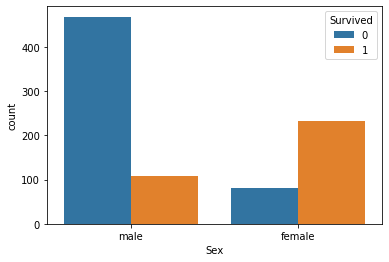

In [126]:
sns.countplot(x=train_df['Sex'], hue=train_df['Survived']) 
# higher survival rate for female

In [127]:
# converts Sex to dummies
train_df['Sex']=train_df['Sex'].apply(lambda x: 1 if x =='male' else 0)
test_df['Sex']=test_df['Sex'].apply(lambda x: 1 if x=='male' else 0)

###  embarked

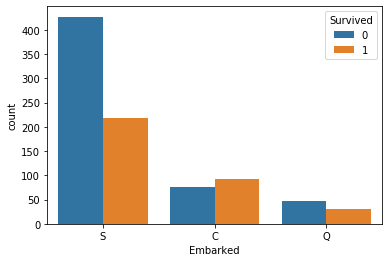

In [130]:
sns.countplot(x='Embarked', data=train_df, hue='Survived')

In [129]:
# filling Embarked missing values by the most frequent value.
train_df['Embarked'].fillna('S', inplace=True)
test_df['Embarked'].fillna('S', inplace=True)

### PClass

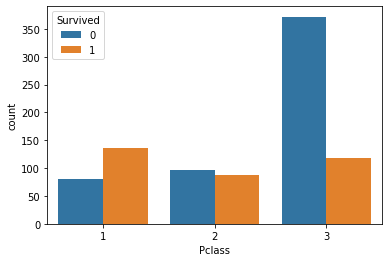

In [131]:
sns.countplot(x='Pclass', data=train_df, hue='Survived')
# PClass 3 passengers have lower chance of survival compared to Class 2 and 1. 
# majority of passengers had PClass 3 tickets.  

### name

In [132]:
# creates a column for name titles
train_df['Name_Title']=train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0])
test_df['Name_Title']=test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0])

In [133]:
# check the number of passengers with similar title
train_df['Name_Title'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Col               2
 Major             2
 Mlle              2
 Mme               1
 Don               1
 Lady              1
 Capt              1
 Sir               1
 Jonkheer          1
 Ms                1
 the Countess      1
Name: Name_Title, dtype: int64

In [134]:
# assigning group of titles a code
title_dict={' Mr': 1,
 ' Miss': 5,
 ' Mrs': 2,
 ' Master': 5,
 ' Dr': 5,
 ' Rev': 4,
 ' Col': 5,
 ' Major': 5,
 ' Mlle': 2,
 ' Ms': 2,
 ' Sir': 5,
 ' Jonkheer': 5,
 ' the Countess': 5,
 ' Mme': 5,
 ' Lady': 2,
 ' Capt': 5,
 ' Don': 5}
train_df['Name_Title']=train_df['Name_Title'].map(title_dict)
test_df['Name_Title']=test_df['Name_Title'].map(title_dict)

In [136]:
# there is only one missing value for name title in test data 
test_df['Name_Title'].fillna(value=1, inplace=True)

### age

In [137]:
# missing age values: creates a new field indicating the age was missing
# age on 
train_df['Age_Null_Flag']=train_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
test_df['Age_Null_Flag']=test_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)

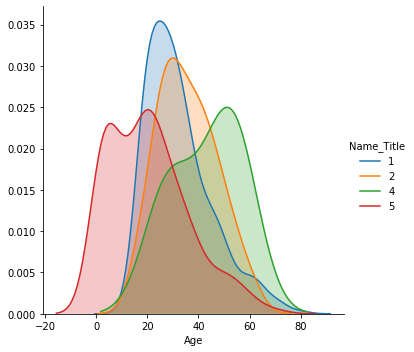

In [138]:
# for a more accurate estimation for missing ages Name_titles and PClass are used as these groups show different age averages. 
g=sns.FacetGrid(train_df, hue="Name_Title", height=5)
g.map(sns.kdeplot, "Age", shade=True).add_legend()

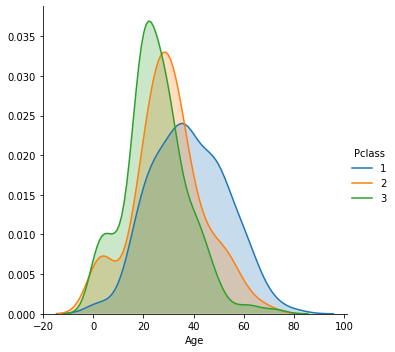

In [139]:
g=sns.FacetGrid(train_df, hue="Pclass", height=5)
g.map(sns.kdeplot, "Age", shade=True).add_legend()


In [141]:
train_df.groupby(['Name_Title','Pclass'])['Age'].mean()

Name_Title  Pclass
1           1         41.580460
            2         32.768293
            3         28.724891
2           1         40.162162
            2         33.547619
            3         33.515152
4           2         43.166667
5           1         32.385806
            2         18.926279
            3         13.343226
Name: Age, dtype: float64

In [140]:
# fills missing ages by mean value using grouping based on the title and Pclass 
train_df['Age'].fillna(train_df.groupby(['Name_Title','Pclass'])['Age'].transform(np.mean),inplace=True)
test_df['Age'].fillna(test_df.groupby(['Name_Title','Pclass'])['Age'].transform(np.mean),inplace=True)

###  SibSp & Parch

In [142]:
# creats a new field for the size of families
# then divides it into three categories: solo, nuclear, anf big 
train_df['Fam_Size']=train_df['Parch']+train_df['SibSp']
train_df['Fam_Size']=train_df['Fam_Size'].apply(lambda x:'Solo' if x==0 else ('Nuclear' if x<=3 else 'Big'))

# test data
test_df['Fam_Size']=test_df['Parch']+test_df['SibSp']
test_df['Fam_Size']=test_df['Fam_Size'].apply(lambda x:'Solo' if x==0 else ('Nuclear' if x<=3 else 'Big'))

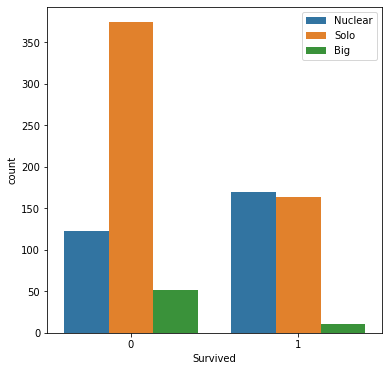

In [143]:
plt.figure(figsize=(6,6))
sns.countplot(x=train_df['Survived'], hue=train_df['Fam_Size'])
plt.legend(loc='upper right')
# individual passengers and those passengers with higher number of dependencies show lower survival rate.  

### ticket

In [144]:
# creates a field for length of ticket numbers
train_df['Ticket_Len']=train_df['Ticket'].apply(lambda x: len(x))
test_df['Ticket_Len']=test_df['Ticket'].apply(lambda x: len(x))

In [145]:
# extrcts the first letter of the ticket number. 
train_df['Ticket_Let']=train_df["Ticket"].apply(lambda x:x[0])
train_df['Ticket_Let']=train_df['Ticket_Let'].apply(lambda x: str(x))

#It groups less frequent letters together to reduce the number of dummy features. 
#'Low tickets' holders were a few and had lower survival rate.
train_df['Ticket_Let']= train_df['Ticket_Let'].replace({'W':'Low_ticket', '4':'Low_ticket', '7':'Low_ticket', '6':'Low_ticket', 
                                      'L':'Low_ticket', '5':'Low_ticket', '8':'Low_ticket', '9':'Other_ticket', 'F':'Other_ticket'})

#test data
test_df['Ticket_Let']=test_df["Ticket"].apply(lambda x:x[0])
test_df['Ticket_Let']=test_df['Ticket_Let'].apply(lambda x: str(x))
test_df['Ticket_Let']= test_df['Ticket_Let'].replace({'W':'Low_ticket', '4':'Low_ticket', '7':'Low_ticket', '6':'Low_ticket', 
                                      'L':'Low_ticket', '5':'Low_ticket', '8':'Low_ticket', '9':'Other_ticket', 'F':'Other_ticket'})

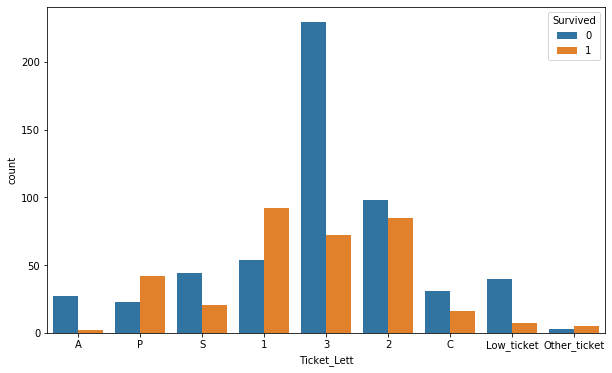

In [146]:
plt.figure(figsize=(10,6))
sns.countplot(x= train_df['Ticket_Lett'],hue=train_df['Survived'])
# tickets starting with '1' had higher survival rate. 

### cabin

In [147]:
# extracts the first letter of cabin number
train_df['Cabin_Letter']=train_df['Cabin'].apply(lambda x:str(x)[0])
test_df['Cabin_Letter']=test_df['Cabin'].apply(lambda x:str(x)[0])

train_df['Cabin_Letter'].replace('n',np.nan, inplace=True)
test_df['Cabin_Letter'].replace('n',np.nan, inplace=True)

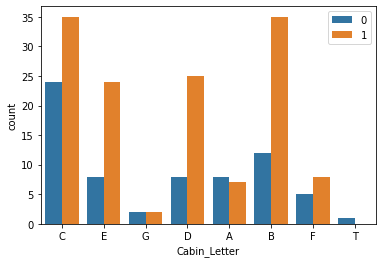

In [148]:
sns.countplot(x='Cabin_Letter', hue='Survived', data=train_df)
plt.legend(loc='upper right', )

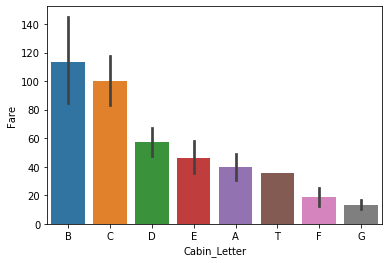

In [149]:
bar_order=train_df.groupby('Cabin_Letter')['Fare'].mean().sort_values(ascending=False).index

sns.barplot(x='Cabin_Letter', y='Fare', data=train_df, order=bar_order)

In [150]:
# creates a field for cabin numbers: splits cabin letter and number. number is the last element of the list. 
# if Cabin is nan, it returns 'an' which should be replaced by nan. 
# Then, the field is converted to int. Values are assigned to 3 ranges.
train_df['Cabin_num']=train_df['Cabin'].apply(lambda x:str(x).split(' ')[-1][1:])
train_df['Cabin_num'].replace('an',np.nan, inplace=True)
train_df['Cabin_num']=train_df['Cabin_num'].apply(lambda x:int(x) if not pd.isnull(x) and x !='' else np.nan)
train_df['Cabin_num'] = pd.qcut(train_df['Cabin_num'],3)

#test data
test_df['Cabin_num']=test_df['Cabin'].apply(lambda x:str(x).split(' ')[-1][1:])
test_df['Cabin_num'].replace('an',np.nan, inplace=True)
test_df['Cabin_num']=test_df['Cabin_num'].apply(lambda x:int(x) if not pd.isnull(x) and x !='' else np.nan)
test_df['Cabin_num'] = pd.qcut(test_df['Cabin_num'],3)

## data preparation

In [151]:
# Drops field that are not needed anymore
train_df.drop(['Name','SibSp','Parch','Ticket','Cabin'], axis=1, inplace=True)
test_df.drop(['Name','SibSp','Parch','Ticket','Cabin'], axis=1, inplace=True)

In [152]:
# changes numbers of categorical features to str for using get_dummies 
train_df['Pclass']=train_df['Pclass'].astype(str)
train_df['Name_Title']=train_df['Name_Title'].astype(str)
train_df['Sex']=train_df['Sex'].astype(str)

test_df['Pclass']=test_df['Pclass'].astype(str)
test_df['Sex']=test_df['Sex'].astype(str)
test_df['Name_Title']=test_df['Name_Title'].astype(int)
test_df['Name_Title']=test_df['Name_Title'].astype(str)

In [153]:
# creates dummies for categorical features 
train_df=pd.get_dummies(train_df)
test_df=pd.get_dummies(test_df)

In [154]:
train_df.head()

,Survived,Age,Fare,Age_Null_Flag,Ticket_Len,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,...,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,"Cabin_num_(1.999, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148.0]"
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,7.2500,0,9,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,38.0,71.2833,0,8,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,1,26.0,7.9250,0,16,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,35.0,53.1000,0,6,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
5,0,35.0,8.0500,0,6,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [155]:
test_df.head()

,Age,Fare,Age_Null_Flag,Ticket_Len,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_C,...,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,"Cabin_num_(1.999, 31.333]","Cabin_num_(31.333, 57.0]","Cabin_num_(57.0, 132.0]"
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,34.5,7.8292,0,6,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
893,47.0,7.0000,0,6,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
894,62.0,9.6875,0,6,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
895,27.0,8.6625,0,6,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
896,22.0,12.2875,0,7,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
#columns that exists in train_df but not in test_df as a result of using qcut and absence of specific categorical value in data 
train_df.columns.difference(test_df.columns)

Index(['Cabin_Letter_T', 'Cabin_num_(1.999, 28.667]',
       'Cabin_num_(28.667, 65.667]', 'Cabin_num_(65.667, 148.0]', 'Survived'],
      dtype='object')

In [156]:
#columns that exists in test_df but not in train_df
test_df.columns.difference(train_df.columns)

Index(['Cabin_num_(1.999, 31.333]', 'Cabin_num_(31.333, 57.0]',
       'Cabin_num_(57.0, 132.0]'],
      dtype='object')

In [159]:
train_df['Cabin_Letter_T'].sum()

1

In [160]:
# only one non-zero value. Better drop the field.
train_df.drop(['Cabin_Letter_T'], axis=1, inplace=True)

In [161]:
# makes consistent naming for Cabin number fields
train_df.rename(inplace=True, columns={'Cabin_num_(1.999, 28.667]':'Cab_num_1', 'Cabin_num_(28.667, 65.667]':'Cab_num_2',
                                       'Cabin_num_(65.667, 148.0]':'Cab_num_3'})

test_df.rename(inplace=True, columns={'Cabin_num_(1.999, 31.333]':'Cab_num_1', 'Cabin_num_(31.333, 57.0]':'Cab_num_2',
                                      'Cabin_num_(57.0, 132.0]':'Cab_num_3'})


##  train / test data

In [162]:
# creates X, y for training and test_df for testing
X=train_df.drop('Survived', axis=1)
X.reset_index(drop=True, inplace=True)
y=train_df['Survived']

test_df.reset_index(drop=True, inplace=True)

In [163]:
# scale the data by fitting the scaler to train data
from sklearn.preprocessing import StandardScaler
rs=StandardScaler()
rs.fit(X)
scaled_X=pd.DataFrame(rs.transform(X),index=X.index, columns=X.columns)

scaled_test=pd.DataFrame(rs.transform(test_df),index=test_df.index, columns=test_df.columns)

## data modeling - classification

In [164]:
# builds model objects

lr=LogisticRegression()
dtree=DecisionTreeClassifier(random_state=1,criterion= 'entropy', max_depth=5, max_features= 6)
rf=RandomForestClassifier()
svc=SVC(C= 4, gamma= 0.001)
gradient_boost= GradientBoostingClassifier()
XGB = XGBClassifier()

# list of models
model_list=[lr,dtree, rf,svc,gradient_boost, XGB]

In [165]:
# function to fit and evaluate models
def cross_val(models):
    for model in models:
        score=np.average(cross_val_score(model, scaled_X.values, y, scoring='accuracy', cv=10))
        print (type(model).__name__,':  ',score)



In [168]:
# prints performance of each classifier        
cross_val(model_list)

LogisticRegression :   0.8395380774032459
DecisionTreeClassifier :   0.8204369538077403
RandomForestClassifier :   0.8249313358302122
SVC :   0.8316729088639201
GradientBoostingClassifier :   0.8372659176029963
XGBClassifier :   0.8148439450686642


In [169]:
# function to find best parameters for each classifier using grid search and improve their performance
def best_estimator (model, grid_pr):
    cv=KFold(8, shuffle=True)
    gr=GridSearchCV(estimator=model, param_grid=grid_pr, scoring='accuracy', cv=cv)
    gr.fit(scaled_X.values, y)
    print ("%.3f"% gr.best_estimator_.score(scaled_X.values,y))
    print (gr.best_params_)
    return gr.best_estimator_

In [170]:
# logistic regression
lr_parameters={'penalty':['l1','l2'], 'C':[0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10]}

lr_grid=best_estimator(lr,lr_parameters)

0.854
{'C': 0.5, 'penalty': 'l2'}


In [171]:
# support vector machine
svc_parameters={'C':[0.001, 0.01, 0.1, 1,1.5,2,2.5,3,4,5, 10],
            'gamma':[0.0001,0.001, 0.01, 0.1, 1]}

svc_grid=best_estimator(svc, svc_parameters )

0.870
{'C': 4, 'gamma': 0.01}


In [173]:
# decision tree
max_feat=range(1,8)
dtree_depth=range(1,20)
dtree_parameters={'max_depth':dtree_depth, 'max_features':max_feat,
                  'criterion':["entropy", "gini"]}
dtree_grid=best_estimator(dtree, dtree_parameters)

0.886
{'criterion': 'gini', 'max_depth': 8, 'max_features': 7}


In [174]:
# random forest classifier
rf_n_estimators=range(10,170,10)
rf_depth=range(1,20,2)
rf_parameters={'n_estimators':rf_n_estimators, 'max_depth':rf_depth}

rf_grid=best_estimator(rf, rf_parameters)

0.915
{'max_depth': 9, 'n_estimators': 30}


In [175]:
# combine the models to produce improved results
model_voting=[('lr',lr_grid), ('rf',rf_grid),('svc',svc_grid),('gradientboost',gradient_boost), ('XGB',XGB)]


vt=VotingClassifier(model_voting)
vt.fit(scaled_X.values, y)

# prints accuracy of the resultant classifier
cross_val([vt])

VotingClassifier :   0.8395131086142322


## predicting test data

In [176]:
prediction_df=pd.DataFrame(vt.predict(scaled_test.values), index=test_ind, columns=['Survived'])

In [177]:
prediction_df.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [178]:
prediction_df.to_csv('Submission_titanic.csv', index=True)